In [ ]:
import pandas as pd
import os



#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'PrePilot2.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accomodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accomodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accomodate['task'] = 'accomodate'
df_predict['task']   = 'predict'


print("Accomodate columns:", df_accomodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'shape_discrete_slider.response', 'shape_direction_slider.response', 'shape_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'shape_discrete_slider.response', 'shape_direction_slider.response',

In [16]:
import ast
def parse_list_column(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_shape', 'training_color']:
    df_accomodate[col] = df_accomodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)


In [18]:
print(df_accomodate['training_tail'][0][0])

R1


In [15]:
import ast
#Convert string representation of list back to list
food_amount = df_predict['food_amount'].apply(ast.literal_eval)
print(food_amount) # float
print(df_predict['training_image_order'][0][0])


0    [8.0, 6.0, 6.0, 3.0, 6.0, 4.0, 3.0, 10.0, 8.0,...
1    [10.0, 7.0, 6.0, 3.0, 7.0, 4.0, 4.0, 5.0, 2.0,...
2    [7.0, 5.0, 5.0, 3.0, 5.0, 7.0, 5.0, 8.0, 6.0, ...
3    [5.0, 9.0, 6.0, 3.0, 6.0, 5.0, 5.0, 7.0, 7.0, ...
Name: food_amount, dtype: object
[


In [19]:
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accomodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)


In [4]:
#Look at average time across task
df_combined['trial_stop_time'].describe()
avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

task
accomodate    493.412150
predict       564.982025
Name: trial_stop_time, dtype: float64


In [5]:
import ast
import matplotlib.pyplot as plt
#Calculate reported food amounts during testing
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        ratings     = ast.literal_eval(df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0])
        categories = ast.literal_eval(df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0])
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        row = df_subset[df_subset['participant'] == i].iloc[0]
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        num_features_relevant = tail_yes + shape_yes + color_yes
        df_participant = pd.DataFrame(list(zip(
            [i]*len(ratings),  # Repeat participant ID and task to match the number of ratings
            ratings,
            [task]*len(ratings), # Repeat participant ID and task to match the number of ratings
            categories,
            [num_features_relevant]*len(ratings)
        )), columns=['participant', 'ratings', 'task', 'category', 'num_features_relevant'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)




task        category
accomodate  high        6.5000
            low         5.1250
            medium      5.3125
predict     high        7.2500
            low         4.3750
            medium      4.9375
Name: ratings, dtype: float64


In [11]:
# Group by task, category, and num_features_relevant
avg_ratings_cond_by_relevance = df_average.groupby(
    ['task', 'category', 'num_features_relevant']
)['ratings'].mean().reset_index()



In [12]:
category_order = ['low', 'medium', 'high']
avg_ratings_cond_by_relevance['category'] = pd.Categorical(
    avg_ratings_cond_by_relevance['category'],
    categories=category_order,
    ordered=True
)

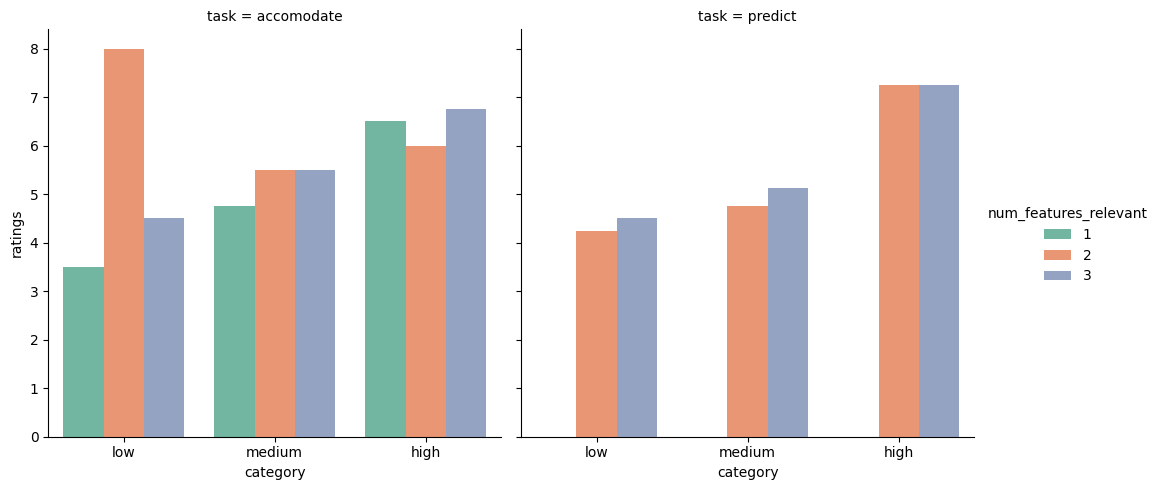

In [13]:
import seaborn as sns
sns.catplot(
    data=avg_ratings_cond_by_relevance,
    x='category', y='ratings',
    hue='num_features_relevant', col='task',
    kind='bar', palette='Set2'
)
plt.show()

<Axes: xlabel='category', ylabel='ratings'>

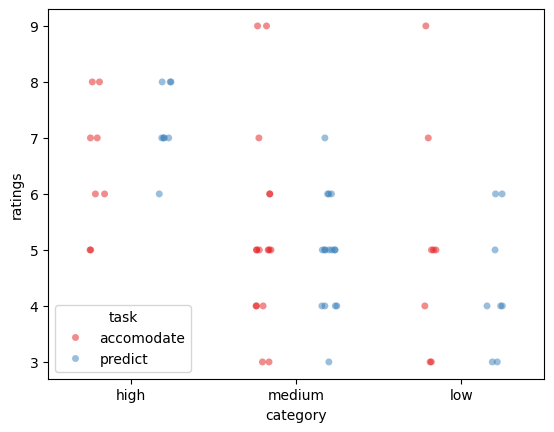

In [14]:
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)

In [17]:
print(df_average.head(20))

    participant  ratings        task category  num_features_relevant
0             1      6.0  accomodate     high                      1
1             1      5.0  accomodate   medium                      1
2             1      3.0  accomodate      low                      1
3             1      5.0  accomodate   medium                      1
4             1      5.0  accomodate   medium                      1
5             1      7.0  accomodate     high                      1
6             1      4.0  accomodate      low                      1
7             1      4.0  accomodate   medium                      1
8             2      5.0  accomodate   medium                      2
9             2      3.0  accomodate   medium                      2
10            2      5.0  accomodate     high                      2
11            2      7.0  accomodate      low                      2
12            2      7.0  accomodate     high                      2
13            2      5.0  accomoda

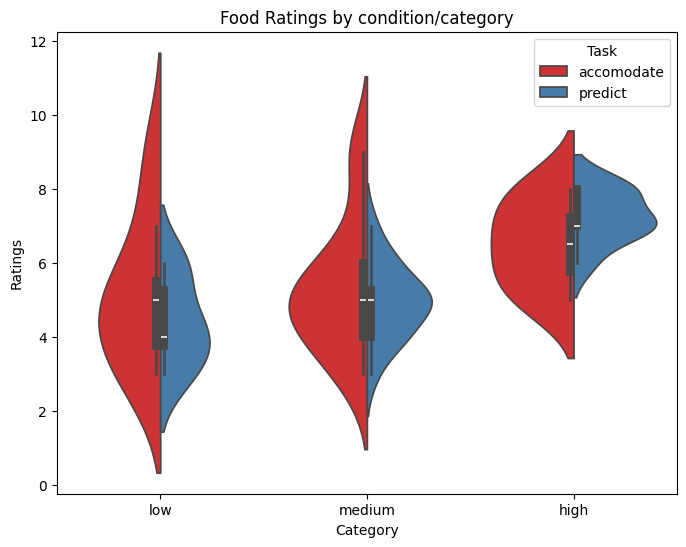

In [15]:
order = ['low', 'medium', 'high']
# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box',    # show box plot of data inside
    order = order
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Food Ratings by condition/category')
plt.legend(title='Task')
#plt.savefig(f'{study}Plots/ViolinRatings.png', bbox_inches='tight')
plt.show()

In [38]:
def decode_rel(rel_values):
    """
    rel_values: Series of lists of rel codes
    """

    flat_vals = []
    for v in rel_values:
        if isinstance(v, list):
            flat_vals.extend(v)

    flat_vals = pd.Series(flat_vals).dropna().unique()

    if len(flat_vals) == 0:
        return pd.Series({'feature_relevance': np.nan})

    # irrelevant: only I-codes
    if all(v.startswith('I') for v in flat_vals):
        return pd.Series({'feature_relevance': 'irrelevant'})

    # relevant: contains R or L
    if any(v.startswith(('R', 'L')) for v in flat_vals):
        return pd.Series({'feature_relevance': 'relevant'})

    raise ValueError(f"Unexpected rel codes: {flat_vals}")


feature_relevance_rows = []

for (cond, task), subdf in df_combined.groupby(['conditionOrder', 'task']):
    for feat in ['tail', 'color', 'shape']:
        relevance = decode_rel(subdf[f'training_{feat}'])

        feature_relevance_rows.append({
            'conditionOrder': cond,
            'task': task,
            'feature_dimension': feat,
            'feature_relevance': relevance
        })

df_feature_relevance = pd.DataFrame(feature_relevance_rows)
print(df_feature_relevance)

    conditionOrder        task feature_dimension  \
0                1  accomodate              tail   
1                1  accomodate             color   
2                1  accomodate             shape   
3                1     predict              tail   
4                1     predict             color   
5                1     predict             shape   
6                2  accomodate              tail   
7                2  accomodate             color   
8                2  accomodate             shape   
9                2     predict              tail   
10               2     predict             color   
11               2     predict             shape   
12               3  accomodate              tail   
13               3  accomodate             color   
14               3  accomodate             shape   
15               3     predict              tail   
16               3     predict             color   
17               3     predict             shape   
18          

In [41]:
features = ['shape', 'color', 'tail']
long_rows = []

for _, row in df_combined.iterrows():
    for feat in features:
        long_rows.append({
            'participant': row['participant'],
            'conditionOrder': row['conditionOrder'],
            'task': row['task'],
            'feature_dimension': feat,

            'discrete': row[f'{feat}_discrete_slider.response'],
            'direction': row[f'{feat}_direction_slider.response'],
            'continuous': row[f'{feat}_continuous_slider.response'],
        })

df_long = pd.DataFrame(long_rows)
print(df_long.head(10))

   participant  conditionOrder        task feature_dimension discrete  \
0            1               4  accomodate             shape      Yes   
1            1               4  accomodate             color       No   
2            1               4  accomodate              tail       No   
3            2               1  accomodate             shape       No   
4            2               1  accomodate             color      Yes   
5            2               1  accomodate              tail      Yes   
6            3               3  accomodate             shape      Yes   
7            3               3  accomodate             color      Yes   
8            3               3  accomodate              tail      Yes   
9            4               2  accomodate             shape      Yes   

       direction  continuous  
0         Square         5.0  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4           Blue         4.0  
5  Having 

In [45]:
df_long = df_long.merge(
    df_feature_relevance,
    on=['conditionOrder', 'task', 'feature_dimension'],
    how='left'
)
print(df_long.head(21))

    participant  conditionOrder        task feature_dimension discrete  \
0             1               4  accomodate             shape      Yes   
1             1               4  accomodate             color       No   
2             1               4  accomodate              tail       No   
3             2               1  accomodate             shape       No   
4             2               1  accomodate             color      Yes   
5             2               1  accomodate              tail      Yes   
6             3               3  accomodate             shape      Yes   
7             3               3  accomodate             color      Yes   
8             3               3  accomodate              tail      Yes   
9             4               2  accomodate             shape      Yes   
10            4               2  accomodate             color      Yes   
11            4               2  accomodate              tail      Yes   
12            5               2     pr